In this notebook, we attempt to attack VAE (and graphite?). We have one (partial) run of the algorithm (on a smallish dataset): can we infer which samples are in the training set?

In [1]:
import pickle
import numpy as np
import networkx as nx

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Loading training data

Load the outputs that we have carefully generated.

In [3]:
def load_graphs(filename):
    with open(filename, 'rb') as ff:
        return [nx.from_edgelist(l) for l in pickle.load(ff)]

In [4]:
training_graphs = load_graphs('graphrnn/GraphRNN_RNN_custom_multiple_tapas_tu_none_4_128__train_0_edgelist.pkl')
print(len(training_graphs))

100


In [5]:
synthetic_graphs = load_graphs('vae/tapas_tu_graphs/tapas_tu_our_vae_generated_graph.pkl')
print(len(synthetic_graphs))

99


This is the code we used to generate training samples. It can be used to produce fresh testing. samples.

In [6]:
def gen():
    n = np.random.randint(20, 40)
    m = np.random.randint(3, 7)
    return nx.barabasi_albert_graph(n=n, m=m)

In [7]:
def gen_many(N):
    return [gen() for _ in range(N)]

With this, we can divide the test set into "known" training samples and "unknown" ones.

In [8]:
np.random.shuffle(training_graphs)

In [9]:
num_train = 80

positive_train = training_graphs[:num_train]
positive_test = training_graphs[num_train:]

negative_train = gen_many(num_train)
negative_test = gen_many(len(positive_test))

## Attack methodology

Given a graph kernel $k$, a record $G$ and a dataset of synthetic graphs $\tilde{D} = (\tilde{G}_1, \dots, \tilde{G}_m)$, we first compute the feature vector for $G$ as

$$\phi(G) = \left(k(G, \tilde{G}_i)\right)_{i \in [m]} \in \mathbb{R}^m.$$

Then, we must learn a rule to predict whether $G$ was found in the training (private) dataset $D$ used to generate $\tilde{D}$. Ideally, this rule should be relatively simple, as we don't have many training samples. Recall from previous discussions that what we really want is a _score_ that estimates membership probability: $\sigma(\tilde{d}, G) \approx \mathbb{P}[G \in D~|~\tilde{D}=\tilde{d}]$.

Another source of complexity is that the _ordering_ of the graphs in $\tilde{D}$ is arbitrary, and the rule should be symmetrical in the positions of individual synthetic graphs (i.e., permutation invariant). This does not really matter in the train-vs-test setup (maybe it can be helpful for samples tested _on one specific dataset_ to know the position of specific synthetic graphs, and interpret entries of $\phi(G)$ differently), but is crucial to allow the rule learned to generalise to other synthetic datasets!

Here are some options to consider:

1. Simple scores: $min_i \phi_i(G)$, $\frac{1}{m}\sum_i\phi_i(G)$, $perc_{\delta}(\phi(G))$ for $\delta = 0.1$. The rule learned is a simple threshold selected over training samples.
2. Function-of-histogram: first, compute a "histogram" of the values in $\phi(G)$, e.g. 10 bins between a (carefully selected) min and max, $h(\phi(G)) \in \mathbb{R}^k$ for $k \ll m$. Then, learn a function $\sigma_\theta$ of this histogram.
3. Function-of-neighbourhood: a similar idea, using as feature a (sorted) vector of the $k$ highest scores.
4. Machine Learning: learn $\theta$ such that $\sigma_\theta \circ \phi (G) \approx \mathbb{P}[G \in D]$. Note that $\tilde{D}$ is not explicitly referenced in this expression, meaning that this model is unlikely to generalise to other synthetic datasets (informally). In general, it also suffers from the permutation issue.

First, initialise the kernel.

In [10]:
import grakel
from grakel.utils import graph_from_networkx

def _grak(graphs):
    # Add a label to the graphs, for compatibility with grakel.
    for G in graphs:
        # Relabel the graph nodes (useful for the kernel).
        nx.set_node_attributes(G, dict(zip(G.nodes, range(len(G.nodes)))), "label")
    return graph_from_networkx(graphs, node_labels_tag="label")

In [11]:
from grakel import WeisfeilerLehman, VertexHistogram
kernel = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)

In [12]:
kernel.fit(_grak(synthetic_graphs))

WeisfeilerLehman(n_iter=4, normalize=True)

Compute the feature vectors.

In [13]:
X_train = kernel.transform(_grak(positive_train + negative_train))
y_train = np.array([True] * len(positive_train) + [False] * len(negative_train))

In [14]:
X_test = kernel.transform(_grak(positive_test + negative_test))
y_test = np.array([True] * len(positive_test) + [False] * len(negative_test))

### 1. Score-based attacks

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

In [16]:
def max_accuracy(true_label, scores):
    fpr, tpr, _ = roc_curve(true_label, scores)
    return np.max((tpr+(1-fpr))/2)

In [17]:
def evaluate_score(scoref):
    score_train = scoref(X_train)
    score_test = scoref(X_test)
    lb = min(score_train.min(), score_test.min())
    ub = max(score_train.max(), score_train.max())
    bins = np.linspace(lb, ub, 21)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(score_train[y_train], bins=bins, facecolor='g', alpha=.5)
    plt.hist(score_train[~y_train], bins=bins, facecolor='r', alpha=.5)
    plt.subplot(1, 3, 2)
    plt.hist(score_test[y_test], bins=bins, facecolor='g', alpha=.5)
    plt.hist(score_test[~y_test], bins=bins, facecolor='r', alpha=.5)
    plt.subplot(1, 3, 3)
    plt.plot([0,1], [0,1], 'k--', alpha=.1)
    fp_train, tp_train, _ = roc_curve(y_train, score_train)
    fp_test, tp_test, _ = roc_curve(y_test, score_test)
    plt.plot(fp_train, tp_train, 'g', label='Train')
    plt.plot(fp_test, tp_test, 'r', label='Test')
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend()

    ev = [('AUC', roc_auc_score), ('Accuracy', max_accuracy)]
    for label, f in ev:
        print(f'Train {label.ljust(8)} ', f(y_train, score_train))
        print(f'Test {label.ljust(8)}  ', f(y_test, score_test))

Train AUC       0.473046875
Test AUC        0.475
Train Accuracy  0.5125
Test Accuracy   0.55


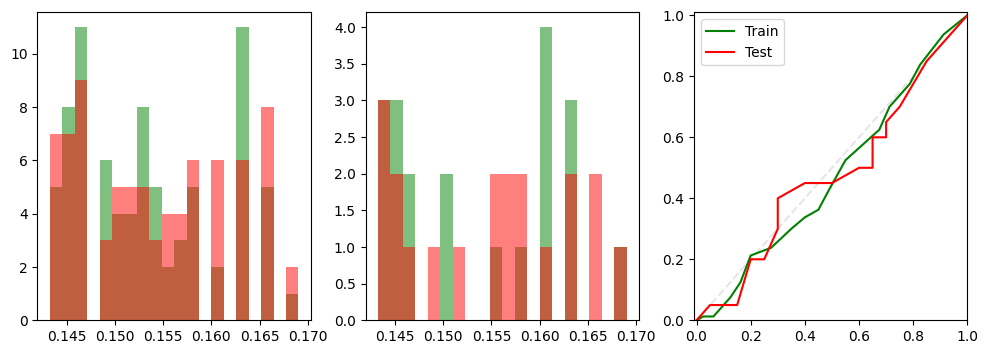

In [18]:
evaluate_score(lambda x: x.min(axis=1))

Train AUC       0.49749999999999994
Test AUC        0.40375
Train Accuracy  0.5125000000000001
Test Accuracy   0.525


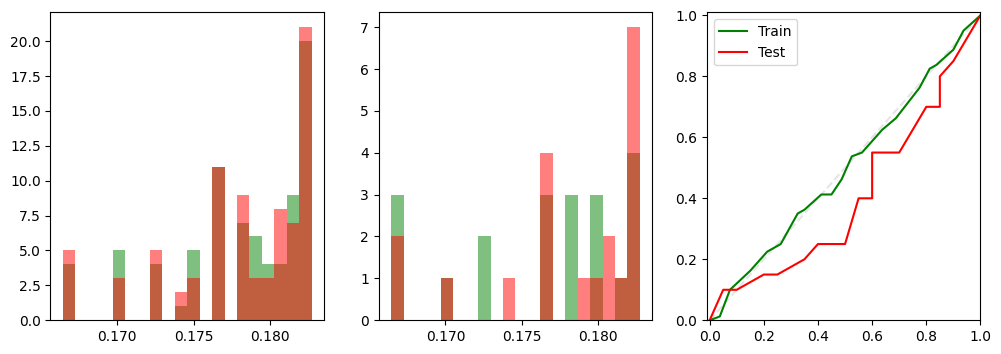

In [19]:
evaluate_score(lambda x: x.mean(axis=1))

Train AUC       0.510625
Test AUC        0.39125
Train Accuracy  0.525
Test Accuracy   0.5


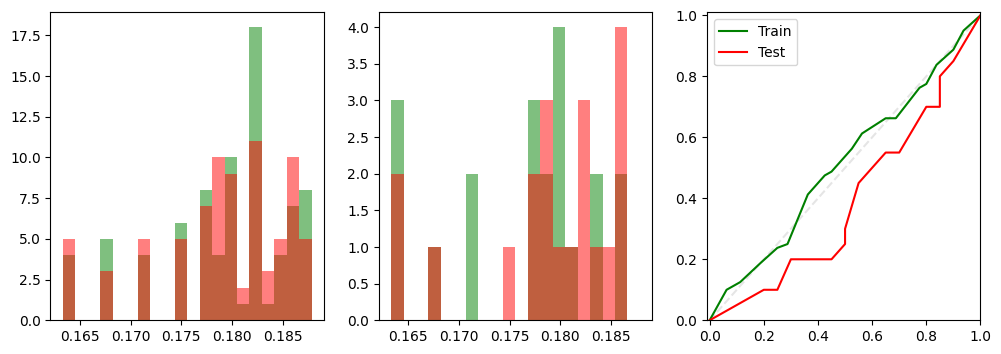

In [20]:
evaluate_score(lambda x: np.median(x, axis=1))

Train AUC       0.51875
Test AUC        0.525
Train Accuracy  0.51875
Test Accuracy   0.525


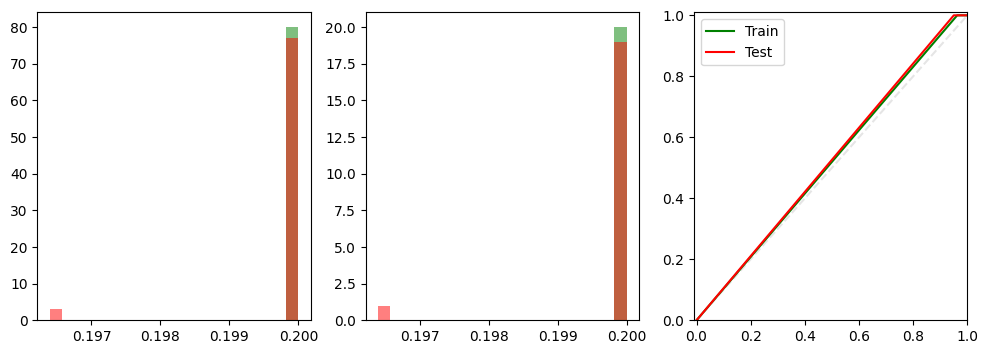

In [21]:
evaluate_score(lambda x: x.max(axis=1))

Train AUC       0.47484374999999995
Test AUC        0.48124999999999996
Train Accuracy  0.5125
Test Accuracy   0.55


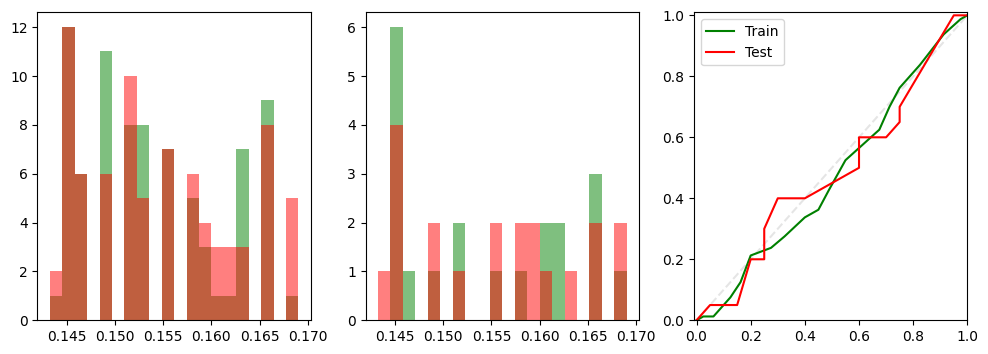

In [22]:
evaluate_score(lambda x: np.percentile(x, 0.95, axis=1))

### 2. Learning-based attacks from histograms

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [24]:
def histogram(X, k, lb=0, ub=1):  # num_entries x num_features
    bins = np.linspace(lb, ub, k+1)
    h = np.zeros((X.shape[0], k))
    for i in range(X.shape[0]):
        h[i,:] = np.histogram(X[i,:], bins=bins)[0]
        h[i,:] = h[i,:] / h[i,:].sum()
    return h

In [25]:
hist = lambda x: histogram(x, lb=0.14, ub=0.22, k=100)

In [26]:
h_train = hist(X_train)
h_test = hist(X_test)

Train AUC       0.628125
Test AUC        0.53625
Train Accuracy  0.6000000000000001
Test Accuracy   0.575


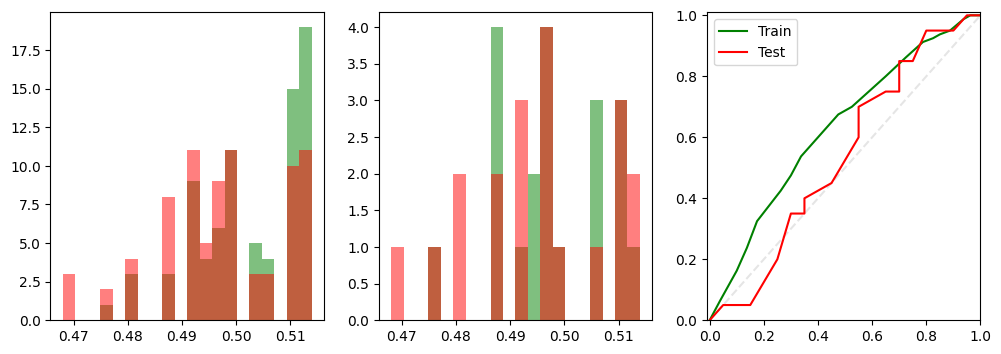

In [27]:
model = LogisticRegression()
model.fit(h_train, y_train)
evaluate_score(lambda x: model.predict_proba(hist(x))[:,1])

Train AUC       0.6420312499999999
Test AUC        0.49125
Train Accuracy  0.6000000000000001
Test Accuracy   0.55


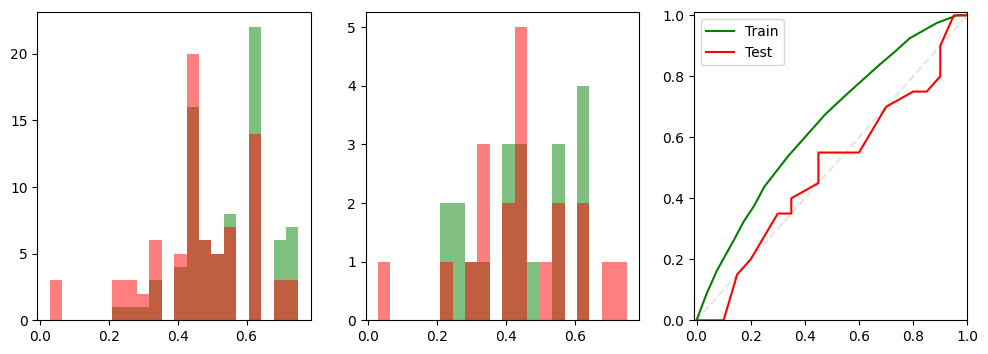

In [28]:
model = RandomForestClassifier()
model.fit(h_train, y_train)
evaluate_score(lambda x: model.predict_proba(hist(x))[:,1])

Pretty bad lol

### 3. Learning-based attack from smallest scores

In [29]:
localize = lambda x: np.sort(x, axis=1)[:,-10:]

Train AUC       0.58671875
Test AUC        0.59125
Train Accuracy  0.575
Test Accuracy   0.6000000000000001


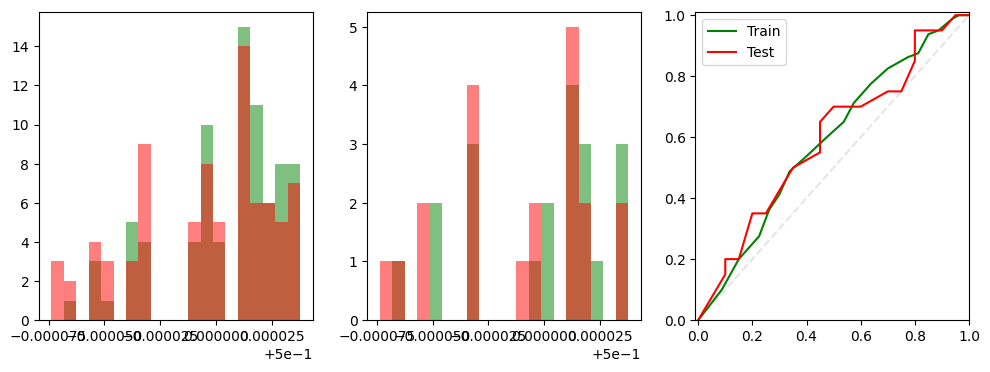

In [30]:
model = LogisticRegression()
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

This is pretty much as good as taking decisions based on the smallest distance.

Train AUC       0.6420312499999999
Test AUC        0.48125000000000007
Train Accuracy  0.6000000000000001
Test Accuracy   0.55


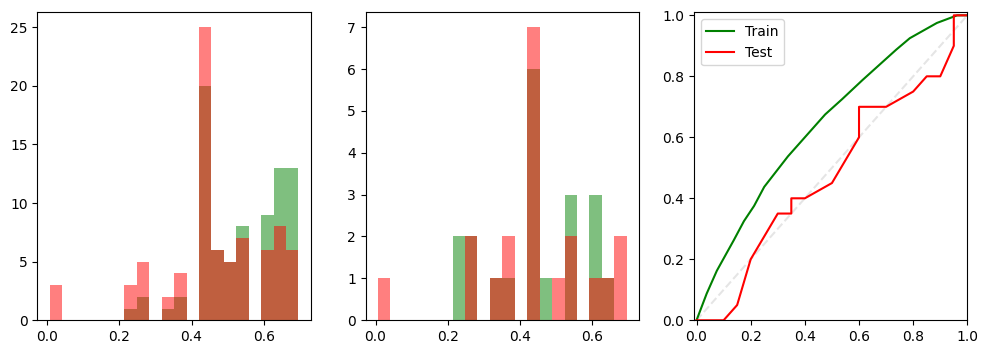

In [31]:
model = RandomForestClassifier()
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

🥳

### 4. Learning-based attacks without any feature engineering

Train AUC       0.51296875
Test AUC        0.39625
Train Accuracy  0.53125
Test Accuracy   0.525


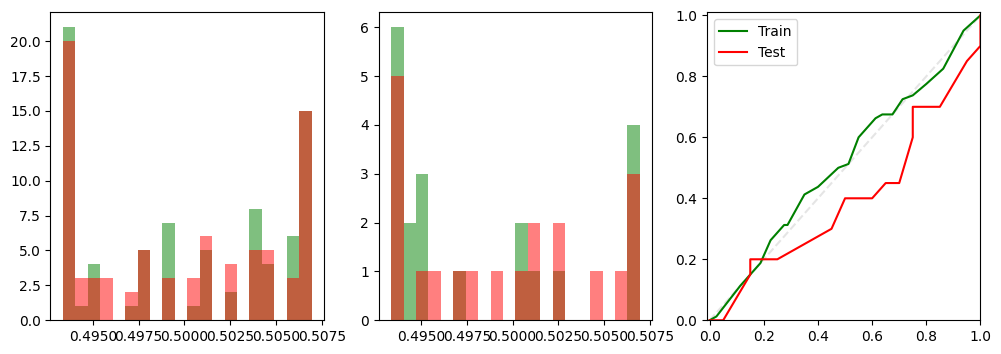

In [32]:
model = LogisticRegression()
model.fit(X_train, y_train)
evaluate_score(lambda x: model.predict_proba(x)[:,1])

Train AUC       0.6420312499999999
Test AUC        0.48375
Train Accuracy  0.6000000000000001
Test Accuracy   0.55


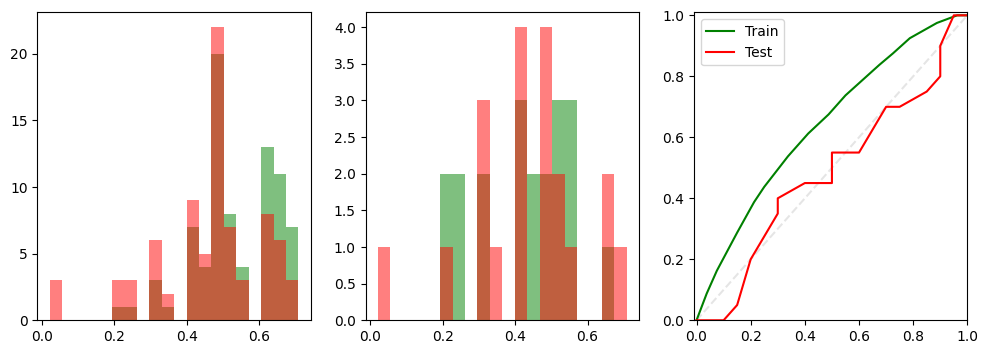

In [33]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
evaluate_score(lambda x: model.predict_proba(x)[:,1])

Train AUC       0.5146875
Test AUC        0.40875
Train Accuracy  0.53125
Test Accuracy   0.525


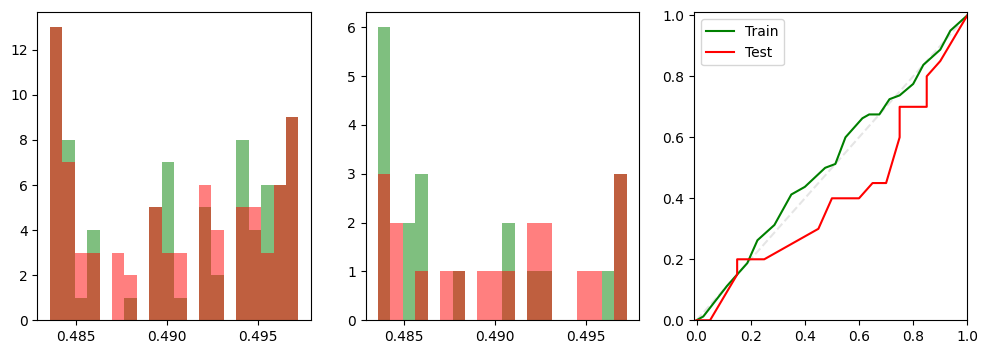

In [34]:
model = MLPClassifier(hidden_layer_sizes=[1000])
model.fit(X_train, y_train)
evaluate_score(lambda x: model.predict_proba(x)[:,1])

This works pretty well _on this dataset_.

---

## Test dataset

We have run GraphRNN on a *second* (completely different) dataset from the same distribution. We will now evaluate the successful attacks on this dataset.

Warning: there will be heavy code re-use in this section. In fact, we will reuse *all* the code from above by swapping X_train and X_test to be the first and second release (rather than subsets of the first release).

First, we rework the `_train` variables to be for the original release.

In [35]:
num_train = len(training_graphs)
X_train = kernel.transform(_grak(training_graphs + gen_many(num_train)))
y_train = np.array([True]*num_train + [False]*num_train)

Second, we load the testing data and use that.

In [36]:
testing_graphs = load_graphs('graphrnn/GraphRNN_RNN_custom_multiple_tapas_tu_test_none_4_128__train_0_edgelist.pkl')
print(len(testing_graphs))

100


In [37]:
synthetic_graphs_2 = load_graphs('vae/tapas_tu_graphs/tapas_tu_test_our_vae_generated_graph.pkl')
print(len(synthetic_graphs_2))

99


Fit the kernel to extract features.

In [38]:
kernel.fit(_grak(synthetic_graphs_2))

WeisfeilerLehman(n_iter=4, normalize=True)

In [39]:
num_test = len(testing_graphs)
X_test = kernel.transform(_grak(testing_graphs + gen_many(num_test)))
y_test = np.array([True]*num_train + [False]*num_train)

We have to redefine this function to reset internal variables.

In [40]:
def evaluate_score(scoref):
    score_train = scoref(X_train)
    score_test = scoref(X_test)
    lb = min(score_train.min(), score_test.min())
    ub = max(score_train.max(), score_train.max())
    bins = np.linspace(lb, ub, 21)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(score_train[y_train], bins=bins, facecolor='g', alpha=.5)
    plt.hist(score_train[~y_train], bins=bins, facecolor='b', alpha=.5)
    plt.subplot(1, 3, 2)
    plt.hist(score_test[y_test], bins=bins, facecolor='g', alpha=.5)
    plt.hist(score_test[~y_test], bins=bins, facecolor='b', alpha=.5)
    plt.subplot(1, 3, 3)
    plt.plot([0,1], [0,1], 'k--', alpha=.1)
    fp_train, tp_train, _ = roc_curve(y_train, score_train)
    fp_test, tp_test, _ = roc_curve(y_test, score_test)
    plt.plot(fp_train, tp_train, 'g', label='Train')
    plt.plot(fp_test, tp_test, 'b', label='Test')
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend()

    ev = [('AUC', roc_auc_score), ('Accuracy', max_accuracy)]
    for label, f in ev:
        print(f'Train {label.ljust(8)} ', f(y_train, score_train))
        print(f'Test {label.ljust(8)}  ', f(y_test, score_test))

#### Attack 4:  random forest classifier without feature engineering.

Train AUC       0.69835
Test AUC        0.5421
Train Accuracy  0.635
Test Accuracy   0.55


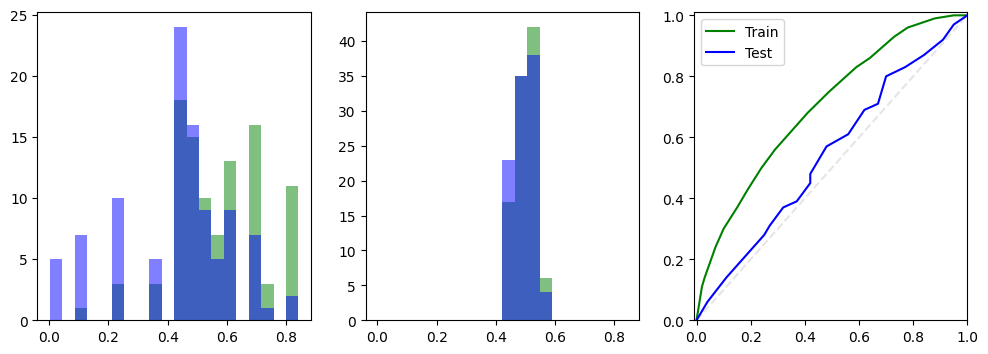

In [41]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
evaluate_score(lambda x: model.predict_proba(x)[:,1])

This attack does not transfer to another dataset, as expected.

#### Attack 2: learning over histograms

Train AUC       0.69855
Test AUC        0.5438
Train Accuracy  0.635
Test Accuracy   0.5499999999999999


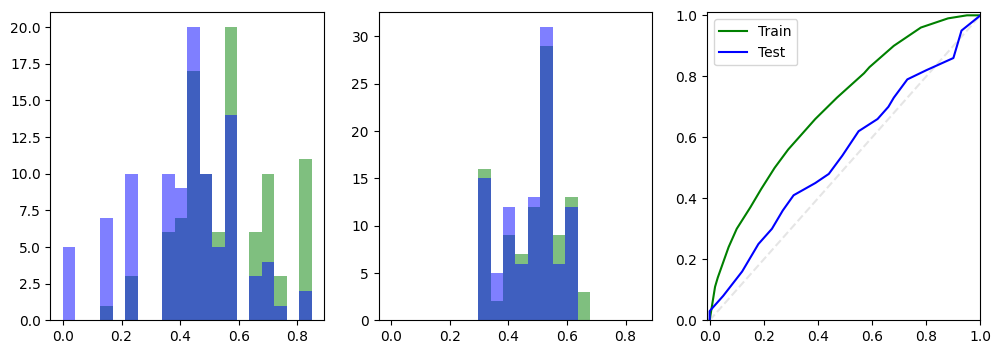

In [42]:
model = RandomForestClassifier()
model.fit(hist(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(hist(x))[:,1])

Train AUC       0.6991499999999999
Test AUC        0.5496
Train Accuracy  0.635
Test Accuracy   0.56


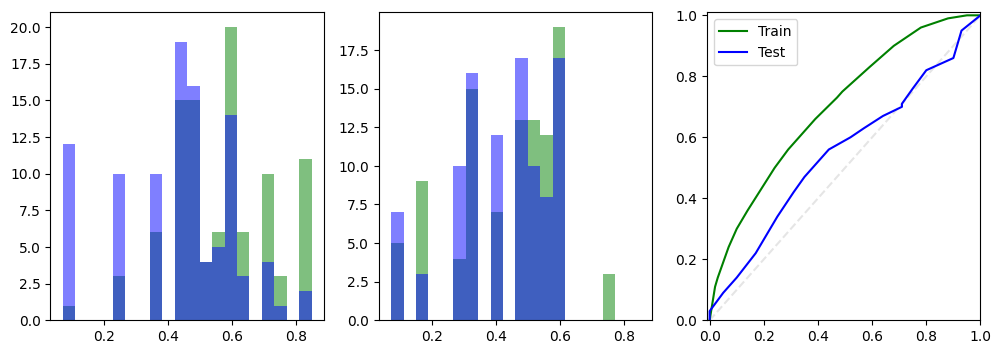

In [43]:
model = MLPClassifier(hidden_layer_sizes=[1000], max_iter=1000)
model.fit(hist(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(hist(x))[:,1])

#### Learning-based over closest neighbours

Train AUC       0.59265
Test AUC        0.6043000000000001
Train Accuracy  0.585
Test Accuracy   0.5800000000000001


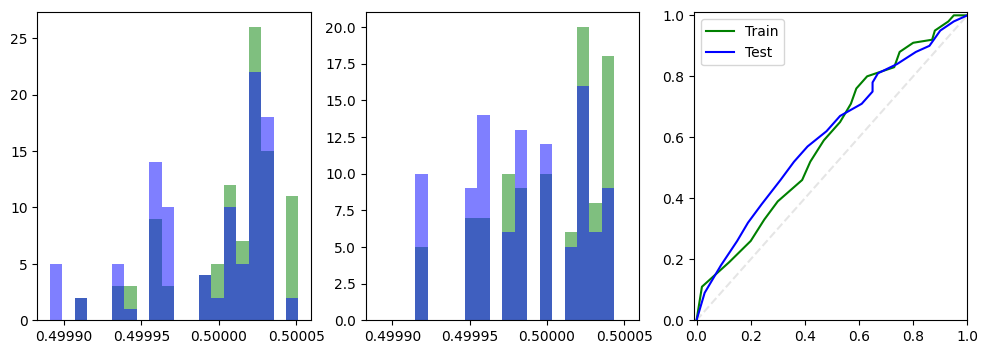

In [51]:
model = LogisticRegression()
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

In [49]:
model.coef_

array([[0.01693444, 0.00877047, 0.00588919, 0.00902944, 0.01940295,
        0.02444831, 0.03076989, 0.01708942, 0.01675366, 0.0090077 ]])

Train AUC       0.69875
Test AUC        0.5169
Train Accuracy  0.635
Test Accuracy   0.53


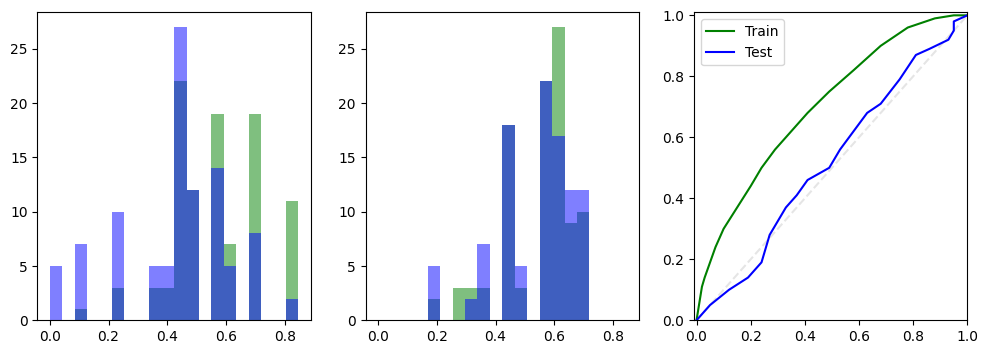

In [45]:
model = RandomForestClassifier()
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

Train AUC       0.44934999999999997
Test AUC        0.4785
Train Accuracy  0.5
Test Accuracy   0.51


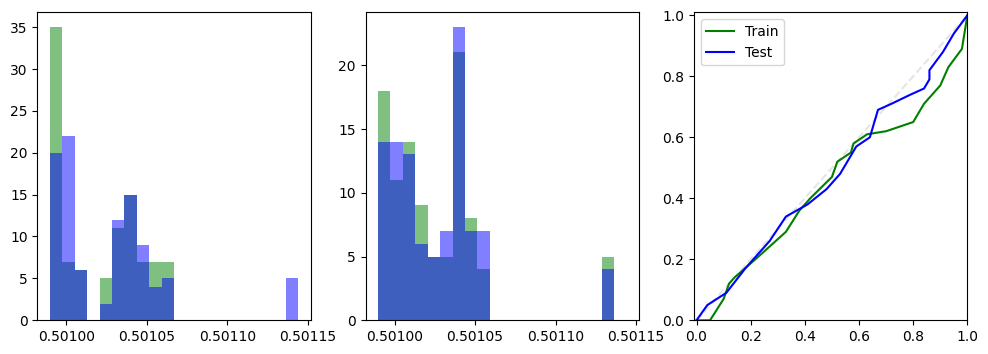

In [46]:
model = MLPClassifier(hidden_layer_sizes=[1000])
model.fit(localize(X_train), y_train)
evaluate_score(lambda x: model.predict_proba(localize(x))[:,1])

#### Attack 1: Score-based from the maximum

Here we do even simpler: no need for all this fancy learning stuff, just extract the score. It works well (better?).

Train AUC       0.525
Test AUC        0.5
Train Accuracy  0.525
Test Accuracy   0.5


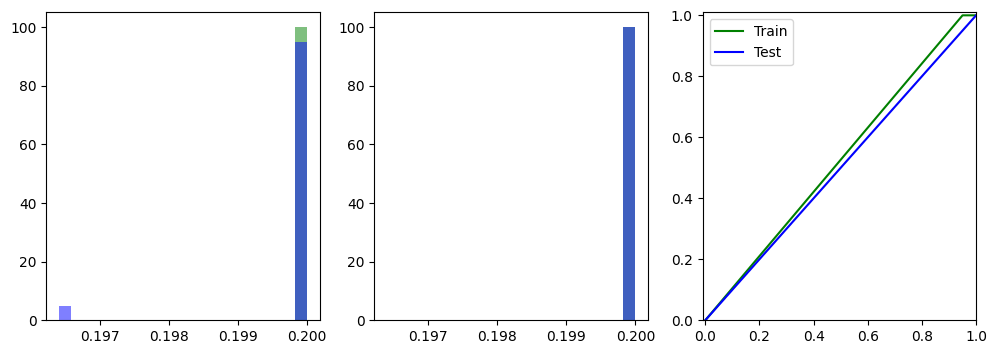

In [47]:
evaluate_score(lambda x: x.max(axis=1))